In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
weights_path = "gdrive/My Drive/weights-DQN-v2.pth"
!pip install 'kaggle-environments>=0.1.6'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/
     |████████████████████████████████| 92kB 2.5MB/s 
     |████████████████████████████████| 61kB 3.4MB/s 
  Found existing installation: jsonschema 2.6.0
    Uninstalling jsonschema-2.6.0:
      Successfully uninstalled jsonschema-2.6.0


In [2]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from kaggle_environments import evaluate, make, utils

# Define Environment

In [3]:
import random

def combined_agent(default_agent, alternate_agent, epsilon):
    def updated_agent(obs, config):
        if (random.random() < epsilon):
            return alternate_agent(obs, config)
        return default_agent(obs,config)
    return updated_agent

from kaggle_environments.envs.connectx.connectx import negamax_agent
from kaggle_environments.envs.connectx.connectx import random_agent

e_greedy_negamax = combined_agent(negamax_agent, random_agent, 0.3)

In [ ]:
from azero import get_greedy_agent
azero_agent = get_greedy_agent(1, 'gdrive/My Drive/net.pth')

In [8]:
class ConnectX(gym.Env):
    def __init__(self, switch_prob=0.5):
        self.env = make('connectx', debug=False)
        self.pair = [None, 'random']
        self.trainer = self.env.train(self.pair)
        self.switch_prob = switch_prob

        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Discrete(config.columns
                * config.rows)

    def switch_trainer(self):
        self.pair = self.pair[::-1]
        self.trainer = self.env.train(self.pair)

    def step(self, action):
        return self.trainer.step(action)

    def reset(self):
        # if np.random.random() < self.switch_prob:
        #    self.switch_trainer()
        return self.trainer.reset()

    def render(self, **kwargs):
        return self.env.render(**kwargs)

In [9]:
# Custom Environment Reward Modification
def check_done(observation):
    done = [False, '']
    # horizontal check
    for i in range(6):
        for j in range(4):
            if observation[i][j] == observation[i][j+1] == observation[i][j+2] == observation[i][j+3] == 1:
                done = [True, 'P1 Horizontal']
            if observation[i][j] == observation[i][j+1] == observation[i][j+2] == observation[i][j+3] == 2:
                done = [True,'P2 Horizontal']
    # vertical check
    for j in range(7):
        for i in range(3):
            if observation[i][j] == observation[i+1][j] == observation[i+2][j] == observation[i+3][j] == 1:
                done = [True,'P1 Vertical']
            if observation[i][j] == observation[i+1][j] == observation[i+2][j] == observation[i+3][j] == 2:
                done = [True,'P2 Vertical']
    #top left to bottom right diagonal check
    for row in range(3):
        for col in range(4):
            if observation[row][col] == observation[row + 1][col + 1] == observation[row + 2][col + 2] == observation[row + 3][col + 3] == 1:
                done = [True,'P1 Diagonal']
            if observation[row][col] == observation[row + 1][col + 1] == observation[row + 2][col + 2] == observation[row + 3][col + 3] == 2:
                done = [True,'P2 Diagonal']
    
    #bottom left to top right diagonal check
    for row in range(5, 2, -1):
        for col in range(3):
            if observation[row][col] == observation[row - 1][col + 1] == observation[row - 2][col + 2] == observation[row - 3][col + 3] == 1:
                done = [True,'P1 Diagonal']
            if observation[row][col] == observation[row - 1][col + 1] == observation[row - 2][col + 2] == observation[row - 3][col + 3] == 2:
                done = [True,'P2 Diagonal']
    return done

In [10]:
env = ConnectX()

# Define Model

In [11]:
class DeepModel(nn.Module):
    def __init__(self, num_states, num_actions, hidden_units):
        super(DeepModel, self).__init__()
        self.hidden_layers = nn.ModuleList([])
        for i in range(len(hidden_units)):
            if i == 0:
                self.hidden_layers.append(nn.Linear(num_states, hidden_units[i]))
            else:
                self.hidden_layers.append(nn.Linear(hidden_units[i - 1], hidden_units[i]))
        self.output_layer = nn.Linear(hidden_units[-1], num_actions)
        
    def forward(self, x):
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        x = self.output_layer(x)
        return x
    
class DQN():
    def __init__(self, num_states, num_actions, hidden_units, gamma=0.99, max_experiences=10000, min_experiences=100, batch_size=32, lr=1e-2):
        self.device = torch.device(('cuda' if torch.cuda.is_available() else 'cpu'))
        self.num_actions = num_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.model = DeepModel(num_states, num_actions, hidden_units).to(self.device)
        print(self.model)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss().to(self.device)
        self.experience = {'s': [], 'a': [], 'r': [], 's2': [], 'done': []}
        self.max_experiences = max_experiences
        self.min_experiences = min_experiences
        self.loss_hist = []
    
    def predict(self, inputs):
        return self.model(torch.from_numpy(inputs).float().to(self.device))
    
    def train(self, net):
        if len(self.experience['s']) < self.min_experiences:
            return 0
        # randomly select n experiences in buffer to form batch
        ids = np.random.randint(low=0, high=len(self.experience['s']), size=self.batch_size)
        states = np.asarray([self.preprocess(self.experience['s'][i]) for i in ids])
        actions = np.asarray([self.experience['a'][i] for i in ids])
        rewards = np.asarray([self.experience['r'][i] for i in ids])
        # prepare labels
        states_next = np.asarray([self.preprocess(self.experience['s2'][i]) for i in ids])
        dones = np.asarray([self.experience['done'][i] for i in ids])
        pred_values = np.max(net.predict(states_next).detach().cpu().numpy(),axis=1)
        actual_values = np.where(dones, rewards, rewards + self.gamma * pred_values)
        actual_values = torch.FloatTensor(actual_values).to(self.device)
        actions = np.expand_dims(actions, axis=1)
        actions_onehot = torch.FloatTensor(self.batch_size, self.num_actions).zero_()
        actions_onehot = actions_onehot.scatter_(1, torch.LongTensor(actions), 1).to(self.device)
        self.optimizer.zero_grad()
        selected_action_values = torch.sum(self.predict(states) * actions_onehot, dim=1).to(self.device)
        loss = self.criterion(selected_action_values, actual_values)
        loss.backward()
        self.optimizer.step()
        
    def get_action(self, state, epsilon):
        if np.random.random() < epsilon:
            return int(np.random.choice([c for c in range(self.num_actions) if state['board'][c] == 0]))
        else:
            prediction = self.predict(np.atleast_2d(self.preprocess(state)))[0].detach().cpu().numpy()
            for i in range(self.num_actions):
                if state['board'][i] != 0:
                    prediction[i] = -1e7
            return int(np.argmax(prediction))
    
    def add_experience(self, exp):
        if len(self.experience['s']) >= self.max_experiences:
            for key in self.experience.keys():
                self.experience[key].pop(0)
        for (key, value) in exp.items():
            self.experience[key].append(value)
    
    def copy_weights(self, net):
        self.model.load_state_dict(net.model.state_dict())
    
    def save_weights(self, path):
        torch.save(self.model.state_dict(), path)
    
    def load_weights(self, path):
        self.model.load_state_dict(torch.load(path, map_location=self.device))
        
    def preprocess(self, state):
        board = (state['board'])[:]
        if state.mark == 1:
            board[board == 2] = -1
        else:
            board[board == 1] = -1
            board[board == 2] = 1
        return board

In [12]:
def play_game(env, TrainNet, TargetNet, epsilon, copy_step):
    rewards = 0
    i = 0
    done = [False]
    observations = env.reset()
    while not done[0]:
        action = TrainNet.get_action(observations, epsilon)
        prev_observations = observations
        (observations, reward, overflow, _) = env.step(action)
        done = check_done(np.array([float(i) for i in observations['board']]).reshape(6,7))
        
        if done[0] == False:
            reward = 0.5
        if 'P2' in done[1]:
            reward = -20
        elif 'P1' in done[1]:
            if 'Vertical' in done[1]:
                reward = 5
            else: 
                reward = 20
        if overflow == True and done[0] == False:
            reward = -99
            done[0] = True
        
        rewards += reward
        
        exp = {
            's': prev_observations,
            'a': action,
            'r': reward,
            's2': observations,
            'done': done[0],
        }
        
        TrainNet.add_experience(exp)
        TrainNet.train(TargetNet)
        
        i+=1
        if i % copy_step == 0:
            TargetNet.copy_weights(TrainNet)
    return rewards

# Training

In [13]:
num_states = env.observation_space.n
num_actions = env.action_space.n
hidden_units = [128, 128, 128, 128]
lr = 1e-2
episodes = 100000
gamma = 0.99
copy_step =25
max_experiences = 10000
min_experiences = 100
batch_size = 32
epsilon = 0.99
decay = 0.9999
min_epsilon = 0.1
precision = 7

In [14]:
env = ConnectX()

all_total_rewards = np.empty(episodes)
all_avg_rewards = np.empty(episodes)
all_epsilons = np.empty(episodes)

TrainNet = DQN(num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr)
TargetNet = DQN(num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr)
TrainNet.save_weights(weights_path)
TrainNet.load_weights(weights_path)
TargetNet.load_weights(weights_path)

DeepModel(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=42, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (output_layer): Linear(in_features=128, out_features=7, bias=True)
)
DeepModel(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=42, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (output_layer): Linear(in_features=128, out_features=7, bias=True)
)


In [ ]:
OpponentNet = DQN(num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr)

def get_opponent_agent():
  OpponentNet.load_weights(weights_path)
  def opponent_agent(observation, configuration):
    return OpponentNet.get_action(observation, 0)
  return opponent_agent

opponent_agent = get_opponent_agent()

DeepModel(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=42, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (output_layer): Linear(in_features=128, out_features=7, bias=True)
)


In [ ]:
from tqdm.notebook import tqdm

pbar = tqdm(range(episodes))

for n in pbar:
    epsilon = max(min_epsilon, epsilon * decay)
    total_reward = play_game(env, TrainNet, TargetNet, epsilon, copy_step)
    all_total_rewards[n] = total_reward
    avg_reward = all_total_rewards[max(0, n - 100):(n + 1)].mean()
    all_avg_rewards[n] = avg_reward
    all_epsilons[n] = epsilon
    
    if n % 100 == 0:
        pbar.set_postfix({
            'episode reward': total_reward,
            'avg (100 last) reward': avg_reward,
        })

    if n % 1000 == 0:
        print('[{}/{}] episode_reward: {:.3f}, avg_reward: {:.3f}, epsilon: {:.5f}'.format(n,episodes,total_reward, avg_reward, epsilon))
        TrainNet.save_weights(weights_path)
        opponent_agent = get_opponent_agent()
        random_opponent_agent = combined_agent(azero_agent, opponent_agent, 0.2)
        env.pair = [None, random_opponent_agent]
        env.trainer = env.env.train(env.pair)

[0/100000] episode_reward: -17.500, avg_reward: -17.500, epsilon: 0.98990
[1000/100000] episode_reward: 25.000, avg_reward: -10.574, epsilon: 0.89569
[2000/100000] episode_reward: -17.500, avg_reward: -13.426, epsilon: 0.81045
[3000/100000] episode_reward: 25.000, avg_reward: -12.975, epsilon: 0.73333
[4000/100000] episode_reward: -18.000, avg_reward: -12.485, epsilon: 0.66354
[5000/100000] episode_reward: -18.000, avg_reward: -14.020, epsilon: 0.60039
[6000/100000] episode_reward: -13.000, avg_reward: -10.812, epsilon: 0.54325
[7000/100000] episode_reward: -17.000, avg_reward: -14.332, epsilon: 0.49155
[8000/100000] episode_reward: 25.500, avg_reward: -9.767, epsilon: 0.44477
[9000/100000] episode_reward: 27.000, avg_reward: -10.015, epsilon: 0.40245
[10000/100000] episode_reward: -15.500, avg_reward: -10.550, epsilon: 0.36415
[11000/100000] episode_reward: -16.500, avg_reward: -13.079, epsilon: 0.32949
[12000/100000] episode_reward: 23.500, avg_reward: -10.446, epsilon: 0.29813
[1300

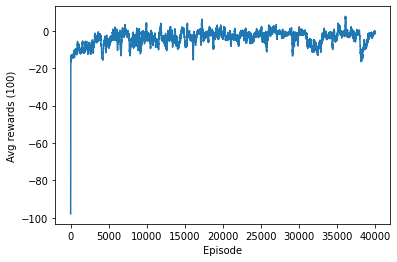

In [ ]:
plt.plot(all_avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Avg rewards (100)')
plt.show()

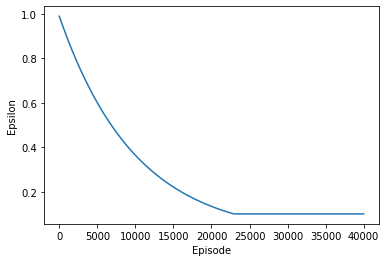

In [ ]:
plt.plot(all_epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

In [ ]:
TrainNet.save_weights(weights_path)

# Test Agent

In [15]:
def my_agent(observation, configuration):
    return TrainNet.get_action(observation, 0)

In [16]:
def mean_reward(rewards):
    return np.round(rewards.count([1,-1])/len(rewards),2)

from nega_agents import return_nega
negamax_agent1 = return_nega(1)
negamax_agent2 = return_nega(2)
negamax_agent3 = return_nega(3)

print("My Agent vs. Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=100)))
print("My Agent vs. Negamax1 Agent:", mean_reward(evaluate("connectx", [my_agent, negamax_agent1], num_episodes=100)))
print("My Agent vs. Negamax2 Agent:", mean_reward(evaluate("connectx", [my_agent, negamax_agent2], num_episodes=100)))
print("My Agent vs. Negamax3 Agent:", mean_reward(evaluate("connectx", [my_agent, negamax_agent3], num_episodes=100)))
print("My Agent vs. Negamax4 Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=100)))
print("Random Agent vs. My Agent:", mean_reward(evaluate("connectx", ["random", my_agent], num_episodes=100)))
print("Negamax1 Agent vs. My Agent:", mean_reward(evaluate("connectx", [negamax_agent1, my_agent], num_episodes=100)))
print("Negamax2 Agent vs. My Agent:", mean_reward(evaluate("connectx", [negamax_agent2, my_agent], num_episodes=100)))
print("Negamax3 Agent vs. My Agent:", mean_reward(evaluate("connectx", [negamax_agent3, my_agent], num_episodes=100)))
print("Negamax4 Agent vs. My Agent:", mean_reward(evaluate("connectx", ["negamax", my_agent], num_episodes=100)))

My Agent vs. Random Agent: 0.89
My Agent vs. Negamax1 Agent: 0.9
My Agent vs. Negamax2 Agent: 0.27
My Agent vs. Negamax3 Agent: 0.75
My Agent vs. Negamax4 Agent: 0.0
Random Agent vs. My Agent: 0.16
Negamax1 Agent vs. My Agent: 0.33
Negamax2 Agent vs. My Agent: 0.72
Negamax3 Agent vs. My Agent: 0.53
Negamax4 Agent vs. My Agent: 1.0
